In [28]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import argparse
import pickle as pkl
import time
from copy import deepcopy

from tqdm import tqdm

import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from random import shuffle
from torch import nn
from torchvision.models import resnet50, ResNet50_Weights

In [29]:
class NCarsImageDataset(Dataset):
    def __init__(self, img_dir_file, transform=None, target_transform=None):
        self.images = np.load(img_dir_file + '_x.npy')
        self.labels = np.load(img_dir_file + '_y.npy')
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # if self.transform:
        #     image = self.transform(image)
        # if self.target_transform:
        #     label = self.target_transform(label)

        return torch.tensor(cv2.resize(image.transpose(1,2,0), dsize=(224, 224), interpolation=cv2.INTER_CUBIC).transpose(2,0,1)), torch.tensor(label)

In [30]:
from torch.utils.data import DataLoader
training_data = NCarsImageDataset("./Datasety/train_EST")
test_data = NCarsImageDataset("./Datasety/test_EST")


generator1 = torch.Generator().manual_seed(42)
test_data, training_data = torch.utils.data.random_split(training_data, [0.3, 0.7], generator=generator1)


In [31]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [35]:
class ResNet(nn.Module):
    def __init__(self, num_classes = 2):
        super(ResNet, self).__init__()
        self.model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.model.conv1 = nn.Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = nn.Linear(in_features=2048, out_features=num_classes, bias=True)
        print(self.model)
        self.model.to("cuda")


    def forward(self, x):
        return self.model.forward(x)
    
    def train_model(self, train_loader, valid_loader, num_epochs = 5, learning_rate=0.01):
        
        total_step = len(train_loader)
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.RMSprop(self.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

        for epoch in range(num_epochs):
            self.train()
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(tqdm(train_loader)):
                # Move tensors to the configured device
                images = images.to("cuda")
                labels = labels.type(torch.LongTensor)
                labels = labels.to("cuda")
                

                optimizer.zero_grad()

                # Forward pass
                outputs = self.forward(images)
                loss = criterion(outputs, labels)
                
                # Backward and optimize
                loss.backward()
                optimizer.step()

                # accuracy
                _, predicted = torch.max(outputs.data, 1)
                correct += (torch.eq(predicted, labels)).sum().item()
                total += labels.size(0)

                del images, labels, outputs

            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
                            .format(epoch+1, num_epochs, i+1, total_step, loss.item(), (float(correct))/total))


            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            self.eval()
            # Validation
            with torch.no_grad():
                correct = 0
                total = 0
                for images, labels in valid_loader:
                    images = images.to("cuda")
                    labels = labels.to("cuda")
                    outputs = self.forward(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (torch.eq(predicted, labels)).sum().item()
                    del images, labels, outputs

                print('Accuracy of the network: {} %'.format( 100 * correct / total))

In [36]:
model = ResNet()

ResNet(
  (conv1): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [37]:
model.train_model(train_dataloader, test_dataloader,num_epochs=50)

100%|██████████| 189/189 [00:48<00:00,  3.93it/s]


Epoch [1/50], Step [189/189], Loss: 1.3970, Accuracy: 0.4968
Accuracy of the network: 51.374370886566005 %


100%|██████████| 189/189 [00:51<00:00,  3.68it/s]


Epoch [2/50], Step [189/189], Loss: 1.5642, Accuracy: 0.5000
Accuracy of the network: 51.21951219512195 %


100%|██████████| 189/189 [00:50<00:00,  3.75it/s]


Epoch [3/50], Step [189/189], Loss: 1.6898, Accuracy: 0.5042
Accuracy of the network: 51.374370886566005 %


100%|██████████| 189/189 [00:50<00:00,  3.73it/s]


Epoch [4/50], Step [189/189], Loss: 1.6260, Accuracy: 0.5015
Accuracy of the network: 48.625629113433995 %


  8%|▊         | 15/189 [00:04<00:47,  3.66it/s]


KeyboardInterrupt: 

tensor(0, dtype=torch.int32)


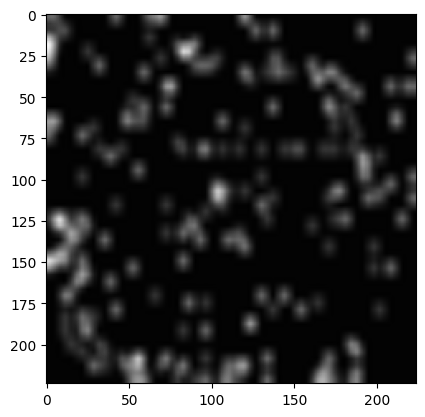

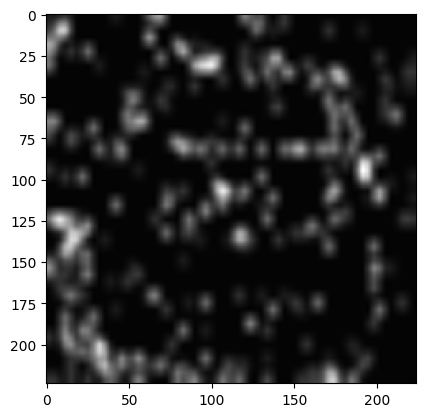

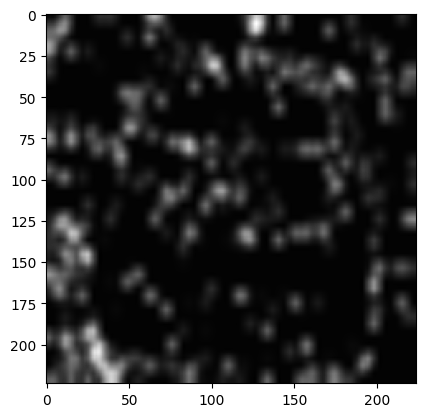

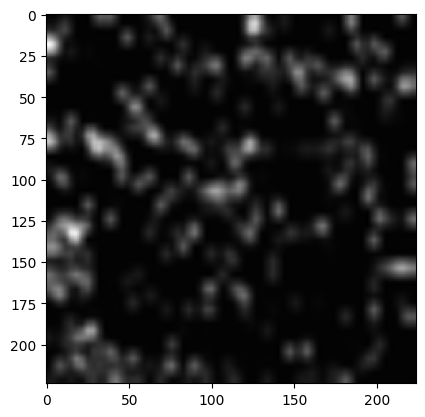

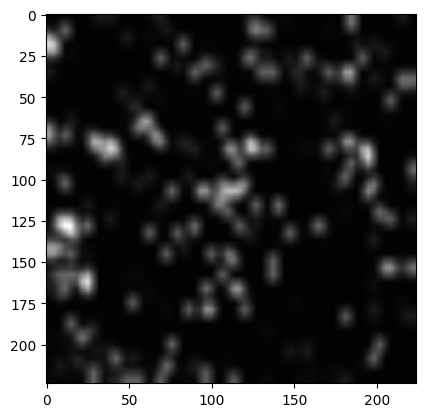

In [ ]:
noBins = 5
pic,label = test_data[500]
print(label)
for i in range(noBins):
        pic2 = pic[i,:,:]
        plt.gray()
        plt.imshow(pic2)
        plt.show()

In [ ]:
from torchvision.models.resnet import ResNet, BasicBlock
from torchvision.datasets import MNIST
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect
import time
from torch import nn, optim
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torch.utils.data import DataLoader

C:\Users\nikos\AppData\Local\Temp\ipykernel_21056\2426850174.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
import torch
import torch.nn as nn  # Import neural network module
import torch.optim as optim  # Import optimization module
from torchvision import datasets, transforms  # Import for datasets and transformations

# Data preparatio


# Model definit

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()  # Common loss function for classification
optimizer = optim.SGD(model.model.parameters(), lr=0.01)  # Stochastic Gradient Descent optimizer

# Training and Evaluation loop
for epoch in range(5):  # Loop for 5 epochs
    model.model.train()  # Set the model to training mode
    for batch_idx, (data, target) in enumerate(train_dataloader):  # Iterate over batches of data
        optimizer.zero_grad()  # Clear gradients from the previous iteration
        output = model.model(data.to("cuda"))  # Forward pass through the model
        loss = loss_fn(output, target.type(torch.LongTensor).to("cuda"))  # Calculate the loss
        loss.backward()  # Compute gradients (backpropagation)
        optimizer.step()  # Update model parameters

    model.model.eval()  # Set the model to evaluation mode 
    test_loss = 0
    correct = 0
    with torch.no_grad():  # Disable gradient calculations for efficiency
        for data, target in test_dataloader:  # Iterate over test data
            output = model.model(data.to("cuda"))  
            test_loss += loss_fn(output, target.type(torch.LongTensor).to("cuda")).item()  # Accumulate test loss 
            pred = output.argmax(dim=1, keepdim=True)  # Get predicted class
            correct += pred.eq(target.view_as(pred).to('cuda')).sum().item()  # Update correct predictions

    test_loss /= len(test_dataloader.dataset)  # Calculate average test loss
    print('\nEpoch: {}, Test Loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        epoch, test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))


Epoch: 0, Test Loss: 0.0638, Accuracy: 4375/8607 (51%)


Epoch: 1, Test Loss: 0.0600, Accuracy: 4385/8607 (51%)


Epoch: 2, Test Loss: 0.0821, Accuracy: 4361/8607 (51%)


Epoch: 3, Test Loss: 0.0635, Accuracy: 4380/8607 (51%)


Epoch: 4, Test Loss: 0.0769, Accuracy: 4373/8607 (51%)

